# Tutorial for Functions.py

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt

In [2]:
import jax.numpy as jnp

In [3]:
from IPython.display import clear_output

In [4]:
from Functions import load_data, minimizer, select_traintest, hyper_minimizer

a simple script to unwrap dictionaries:

In [5]:
def unwrap_dict(d):

    res = []
    
    if isinstance(d, dict):
        for val in d.values():
            res.extend(unwrap_dict(val))
    else:
        if isinstance(d, list): res = d
        else: res = [d]

    return np.hstack(res)

## 4. Ensemble + forward-model refinement

### a. Load data

In [6]:
infos = {}

# Define global properties, valid for all the systems:
infos['global'] = {}
infos['global']['path_directory'] = 'DATA2'
infos['global']['system_names'] = ['AAAA','CAAU']

# Then, define properties which are specific of each system, like experimental data and observables
# If some properties are the same for all the systems, you can store them just once in infos['global']
infos['global']['g_exp'] = ['backbone1_gamma_3J']#, 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs']
infos['global']['forward_qs'] = ['backbone1_gamma']#, 'backbone2_beta_epsilon','sugar']
# infos['global']['obs'] = ['NOEs']
infos['global']['forward_coeffs'] = 'original_fm_coeffs'

# Select the stride for the frames
stride = 1000

In [7]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs = None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2-fm_coeffs[1]*forward_qs_cos['backbone1_gamma']+fm_coeffs[2]}#,
        # 'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2-fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon']+fm_coeffs[5],
        # 'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2-fm_coeffs[7]*forward_qs_cos['sugar']+fm_coeffs[8] }

    return forward_qs_out

In [8]:
infos['global']['forward_model'] = forward_model_fun

In [9]:
data = load_data(infos, stride = 1000)

loading data from directory...
loading  AAAA
loading  CAAU
done


In [10]:
def forward_model_regularization(coeffs,coeffs_0):
    regularization = (
    3/8*(coeffs[0]-coeffs_0['A_gamma'])**2+1/2*(coeffs[1]-coeffs_0['B_gamma'])**2+(coeffs[2]-coeffs_0['C_gamma'])**2+(coeffs[0]-coeffs_0['A_gamma'])*(coeffs[2]-coeffs_0['C_gamma'])+
    3/8*(coeffs[3]-coeffs_0['A_beta'])**2+1/2*(coeffs[4]-coeffs_0['B_beta'])**2+(coeffs[5]-coeffs_0['C_beta'])**2+(coeffs[3]-coeffs_0['A_beta'])*(coeffs[5]-coeffs_0['C_beta'])+
    3/8*(coeffs[6]-coeffs_0['A_sugar'])**2+1/2*(coeffs[7]-coeffs_0['B_sugar'])**2+(coeffs[8]-coeffs_0['C_sugar'])**2+(coeffs[6]-coeffs_0['A_sugar'])*(coeffs[8]-coeffs_0['C_sugar']))

    return regularization

In [11]:
regularization = {'force_field_reg': 'KL divergence', 'forward_model_reg': forward_model_regularization}

### b. Minimize

In [12]:
Result = minimizer(data, regularization = regularization, alpha = 1, gamma = 1)

In [14]:
vars(Result).keys()

dict_keys(['loss', 'pars', 'mini', 'min_lambdas', 'minis', 'intermediates', 'time', 'reg_fm', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])

In [17]:
vars(Result.intermediates).keys()

dict_keys(['loss', 'pars', 'lambdas', 'minis'])

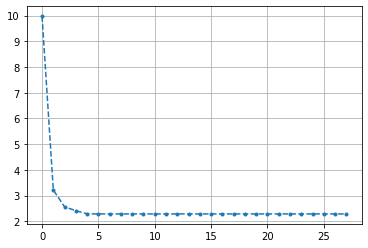

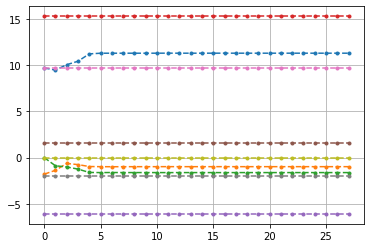

In [22]:
plt.plot(Result.intermediates.loss, '.--')
plt.grid()

plt.figure()
inter_pars = Result.intermediates.pars
for i in range(inter_pars.shape[1]):
    plt.plot(Result.intermediates.pars[:,i], '.--')
plt.grid()

### c. Search for optimal hyper-parameters

In [23]:
hyper_minimizer(data, regularization = regularization, starting_alpha = 100, starting_gamma = 100, random_states = [0])


Input random_state employed both for test_obs and test_frames
log10 hyperpars:  [DeviceArray(2., dtype=float64), DeviceArray(2., dtype=float64)] ['alpha', 'gamma']
tot chi2:  22.353376543097212
tot gradient:  [0.66327126 4.05980457]
log10 hyperpars:  [2. 2.] ['alpha', 'gamma']
tot chi2:  22.353376543097212
tot gradient:  [0.66327126 4.05980457]
log10 hyperpars:  [1.83715012 1.00321521] ['alpha', 'gamma']
tot chi2:  12.476867395008014
tot gradient:  [ 0.54426244 15.14864544]
log10 hyperpars:  [ 1.18575058 -2.98392394] ['alpha', 'gamma']
tot chi2:  0.901878355898672
tot gradient:  [ 0.30855595 -0.03034611]


      fun: 0.901878355898672
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 0.30855595, -0.03034611])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([ 1.18575058, -2.98392394])

## 5. Fully combined refinement

### a. Load data

In [6]:
infos = {}

# Define global properties, valid for all the systems:
infos['global'] = {}
infos['global']['path_directory'] = 'DATA2'
infos['global']['system_names'] = ['AAAA','CAAU']

# Then, define properties which are specific of each system, like experimental data and observables
# If some properties are the same for all the systems, you can store them just once in infos['global']
infos['global']['g_exp'] = ['backbone1_gamma_3J']#, 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs']
infos['global']['forward_qs'] = ['backbone1_gamma']#, 'backbone2_beta_epsilon','sugar']
# infos['global']['obs'] = ['NOEs']
infos['global']['forward_coeffs'] = 'original_fm_coeffs'

# Select the stride for the frames
stride = 1000

In [7]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs = None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2-fm_coeffs[1]*forward_qs_cos['backbone1_gamma']+fm_coeffs[2]}#,
        # 'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2-fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon']+fm_coeffs[5],
        # 'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2-fm_coeffs[7]*forward_qs_cos['sugar']+fm_coeffs[8] }

    return forward_qs_out

In [8]:
infos['global']['forward_model'] = forward_model_fun

In [9]:
def ff_correction(pars, f):

    out = jnp.matmul(pars, (f[:,[0,6,3,9]]+f[:,[1,7,4,10]]+f[:,[2,8,5,11]]).T)
    return out

In [10]:
infos['global']['ff_correction'] = ff_correction
infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha', 'sin zeta', 'cos zeta']

In [11]:
data = load_data(infos, stride = stride)

loading data from directory...
loading  AAAA
loading  CAAU
done


In [12]:
def forward_model_regularization(coeffs,coeffs_0):
    regularization = (
    3/8*(coeffs[0]-coeffs_0['A_gamma'])**2+1/2*(coeffs[1]-coeffs_0['B_gamma'])**2+(coeffs[2]-coeffs_0['C_gamma'])**2+(coeffs[0]-coeffs_0['A_gamma'])*(coeffs[2]-coeffs_0['C_gamma'])+
    3/8*(coeffs[3]-coeffs_0['A_beta'])**2+1/2*(coeffs[4]-coeffs_0['B_beta'])**2+(coeffs[5]-coeffs_0['C_beta'])**2+(coeffs[3]-coeffs_0['A_beta'])*(coeffs[5]-coeffs_0['C_beta'])+
    3/8*(coeffs[6]-coeffs_0['A_sugar'])**2+1/2*(coeffs[7]-coeffs_0['B_sugar'])**2+(coeffs[8]-coeffs_0['C_sugar'])**2+(coeffs[6]-coeffs_0['A_sugar'])*(coeffs[8]-coeffs_0['C_sugar']))

    return regularization

In [13]:
regularization = {'force_field_reg': 'KL divergence', 'forward_model_reg': forward_model_regularization}

### b. Minimize

In [32]:
Result = minimizer(data, regularization = regularization, alpha = 1, beta = 1, gamma = 1)

In [33]:
vars(Result).keys()

dict_keys(['loss', 'pars', 'mini', 'min_lambdas', 'minis', 'intermediates', 'time', 'weights_P', 'logZ_P', 'reg_ff', 'reg_fm', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])

In [17]:
Result.pars

array([ 0.20581379,  0.1166485 , -0.11218685, -0.28415164, 11.25801233,
       -1.01921506, -1.57684089, 19.39833519, -3.0390469 , -3.33549634,
        9.21284667,  0.49126669, -0.47351348])

In [60]:
Result.mini

      fun: 2.282926673913012
 hess_inv: array([[ 5.37846378e-01, -5.94041901e-03, -4.42145688e-01,
        -1.97232898e-02,  1.63245143e-02, -5.57596041e-03,
        -3.18368396e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-5.94041901e-03,  9.98539836e-01, -1.45645109e-03,
        -1.93951817e-02,  3.69293674e-02,  1.24948465e-02,
        -5.56885853e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-4.42145688e-01, -1.45645109e-03,  5.77666109e-01,
        -3.13187555e-02,  2.83026623e-02,  1.90902714e-02,
        -3.40369824e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.97232898e-02, -1.93951817e-02, -3.13187555e-02,
         1.10665744e+00, -2.77246136e-01, -1.39975049e-01,
         2.38985340e-01,  0.00000000e+00,  0.00000000e+0

In [19]:
Result.minis

{'AAAA':       fun: -10.507619992690685
  hess_inv: array([[1, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 1]])
       jac: array([-5.49653570e-05, -5.47391650e-05,  2.11852284e-04,  3.88328320e-05,
         1.16655592e-04, -1.15083849e-06, -2.84512042e-04, -1.31942980e-04,
        -1.18534050e-05, -1.90803831e-04,  1.35917176e-04,  5.12378532e-05,
         1.47919389e-05, -2.40391759e-05,  1.45694660e-04,  1.06335639e-04,
        -1.59983452e-06,  5.44929690e-04, -1.50328426e-04,  1.46868358e-05,
         1.89647116e-04, -1.12882226e-04, -1.61548533e-05, -7.47772014e-04,
        -1.19459748e-04,  2.01931719e-04, -5.55774763e-05,  1.71100412e-04,
        -1.62825692e-05, -6.40423500e-05,  5.29456805e-05, -3.19958137e-05,
         1.17196685e-04,  8.02226254e-05,  1.14117897e-04, -1.19123958e-06,
         1.26342341e-04,  2.92529391e-04, 

In [16]:
vars(Result.intermediates).keys()

dict_keys(['loss', 'pars', 'lambdas', 'minis'])

In [17]:
np.array(Result.intermediates.lambdas).shape

(28, 16)

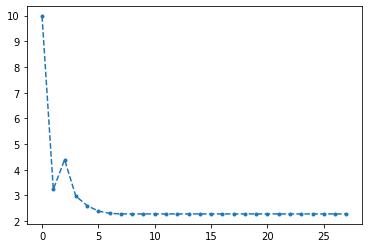

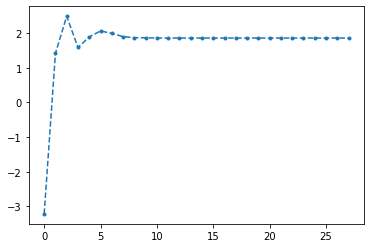

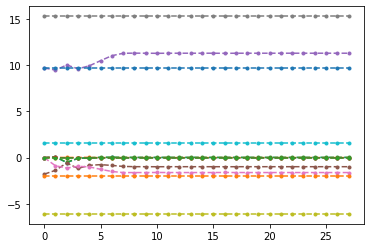

In [18]:
inter_loss = Result.intermediates.loss
plt.plot(inter_loss, '.--')

plt.figure()

inter_lambdas = np.array(Result.intermediates.lambdas)
plt.plot(inter_lambdas[:,0], '.--')

plt.figure()
plt.plot(Result.intermediates.pars, '.--')
plt.show()

In [19]:
Result.abs_difference

{'AAAA': DeviceArray(3.4269942e-05, dtype=float64),
 'CAAU': DeviceArray(3.84937797e-05, dtype=float64)}

### c. Determine optimal hyper-parameters through cross validation

In [20]:
data_train, data_test, test_obs, test_frames = select_traintest(data, random_state = 1)

Input random_state employed both for test_obs and test_frames


In [22]:
delta = 2.0

log10_alphas = np.arange(-2,2+delta,delta)
log10_betas = np.array([-2.0,0.0,2.0])
log10_gammas = log10_alphas

Results = {}

for log10_alpha in log10_alphas:
    Results[log10_alpha] = {}
    for log10_beta in log10_betas:
        Results[log10_alpha][log10_beta] = {}
        for log10_gamma in log10_gammas:
            print(log10_alpha, log10_beta, log10_gamma)
            Results[log10_alpha][log10_beta][log10_gamma] = minimizer(data_train, regularization = regularization, alpha = 10**log10_alpha, beta = 10**log10_beta, gamma = 10**log10_gamma, data_test = data_test)

            clear_output()

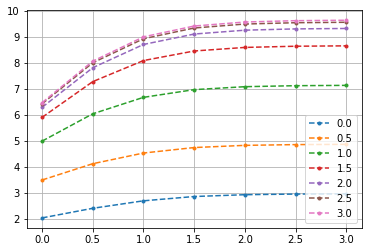

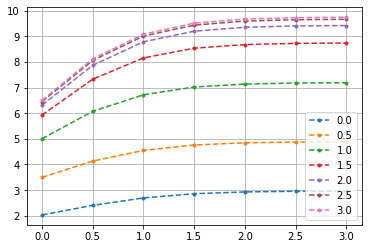

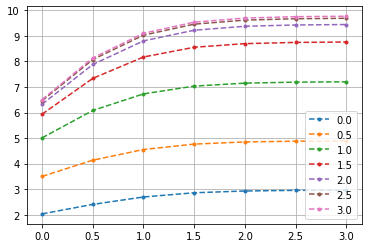

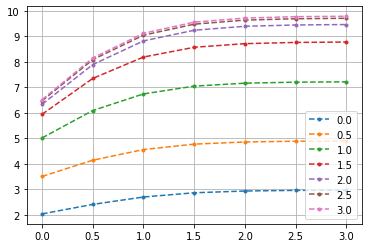

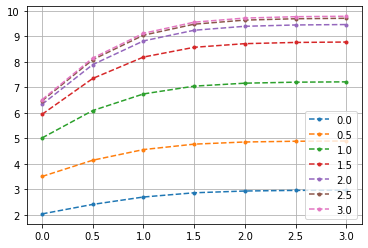

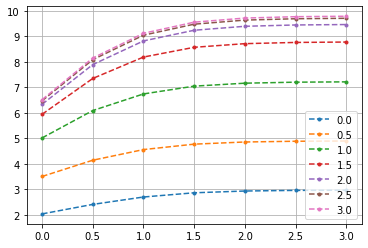

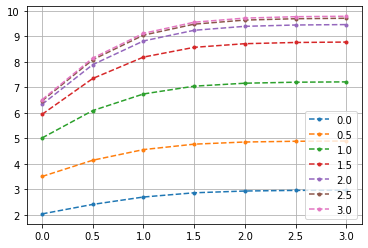

In [127]:
for log10_beta in log10_betas:

    plt.figure()

    for log10_gamma in log10_gammas:
        loss = np.array([Results[log10_alpha][log10_beta][log10_gamma].loss for log10_alpha in log10_alphas])
        plt.plot(log10_alphas, loss, '.--', label = log10_gamma)

    plt.legend()
    plt.grid()

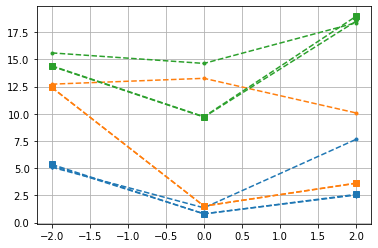

In [28]:
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink', 'tab:gray','tab:olive','tab:cyan']
markers = ['.','v','s','*','D','o','^','<','>','p','P','+','X','d']

for i,log10_beta in enumerate(log10_betas):

    # plt.figure()

    for j,log10_gamma in enumerate(log10_gammas):
        chi2 = np.array([np.sum(unwrap_dict(Results[log10_alpha][log10_beta][log10_gamma].chi2)) for log10_alpha in log10_alphas])
        chi2_test = np.array([np.sum(unwrap_dict(Results[log10_alpha][log10_beta][log10_gamma].chi2_test)) for log10_alpha in log10_alphas])
        chi2_new_obs = np.array([np.sum(unwrap_dict(Results[log10_alpha][log10_beta][log10_gamma].chi2_new_obs)) for log10_alpha in log10_alphas])

        loss = np.array([Results[log10_alpha][log10_beta][log10_gamma].loss for log10_alpha in log10_alphas])
        
        # plt.plot(log10_alphas, loss, markers[i] + '--', color = colors[j], label = log10_gamma)
        # plt.plot(log10_alphas, chi2, markers[i] + '--', color = colors[j], label = log10_gamma)
        plt.plot(log10_alphas, chi2_test, markers[i] + '--', color = colors[j], label = log10_gamma)
        # plt.plot(log10_alphas, chi2_new_obs, markers[i] + '--', color = colors[j], label = log10_gamma)

    # plt.legend()
    plt.grid()

### d. automatic optimization of hyper parameters

In [14]:
hyper_minimizer(data, regularization = regularization, starting_alpha = 100, starting_beta = 1, starting_gamma = 100, random_states = 2)


Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('alpha', 2.0), ('beta', 0.0), ('gamma', 2.0)]


KeyboardInterrupt: 

if you do not specify some hyper parameters, as for example $\gamma$, you are fixing it to $+\infty$ (no refinement in that "direction")

In [53]:
hyper_out = hyper_minimizer(data, regularization = regularization, starting_alpha = 0.1, starting_beta = 10, random_states = 2, gtol = 0.1)


Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('alpha', -0.9999999999999998), ('beta', 1.0)]
tot chi2:  28.050535978184612
tot gradient:  [-23.41717915  -0.09195889]

log10 hyperpars:  [('alpha', 0.009992212381299215), ('beta', 1.0039662235349724)]
tot chi2:  23.218529704974383
tot gradient:  [21.17701877  0.04725389]

log10 hyperpars:  [('alpha', -0.46963406750226966), ('beta', 1.0020827386764306)]
tot chi2:  17.14549663562447
tot gradient:  [-3.79427275 -0.11473703]

log10 hyperpars:  [('alpha', -0.3669318992980608), ('beta', 1.1216298262759157)]
tot chi2:  17.227550737324293
tot gradient:  [ 5.8158668  -0.02828849]

log10 hyperpars:  [('alpha', -0.42653134673513593), ('beta', 1.0522550458966544)]
tot chi2:  17.073776208659613
tot gradient:  [ 0.31939131 -0.07235223]

log10 hyperpars:  [('alpha', -0.4297529259557293), ('beta', 1.1257705063949672)]
tot chi2:  17.06863761890843
tot gradien

In [56]:
vars(hyper_out.intermediate)

{'tot_chi2': DeviceArray([28.05053598, 23.2185297 , 17.14549664, 17.22755074,
              17.07377621, 17.06863762], dtype=float64),
 'tot_gradient': DeviceArray([[-23.41717915,  -0.09195889],
              [ 21.17701877,   0.04725389],
              [ -3.79427275,  -0.11473703],
              [  5.8158668 ,  -0.02828849],
              [  0.31939131,  -0.07235223],
              [  0.06255257,  -0.06224764]], dtype=float64),
 'log10_hyperpars': DeviceArray([[-1.        ,  1.        ],
              [ 0.00999221,  1.00396622],
              [-0.46963407,  1.00208274],
              [-0.3669319 ,  1.12162983],
              [-0.42653135,  1.05225505],
              [-0.42975293,  1.12577051]], dtype=float64)}